In [11]:
from pyarrow import timestamp
from welfareobs.detectron.detectron_configuration import get_configuration
from welfareobs.detectron.detectron_calls import image_tensor, predict
from welfareobs.detectron.welfareobs_dataset import WelfareObsDataset
from detectron2.config import instantiate
from detectron2.checkpoint import DetectionCheckpointer
from welfareobs.handlers.abstract_handler import AbstractHandler
from welfareobs.models.frame import Frame
from welfareobs.models.individual import Individual
from welfareobs.utils.config import Config
from welfareobs.utils.config import Config
import matplotlib.pyplot as plt
import torchvision.transforms as T
import os
import itertools
import numpy as np





In [12]:
#
# Load up the configuration
#
cnf: Config = Config("config/detection.json")
dimensions = cnf.as_int("dimensions")
reid_model_root = cnf.as_string("reid-model-root")
reid_timm_backbone = cnf.as_string("reid-timm-backbone")
segmentation_checkpoint = cnf.as_string("segmentation-checkpoint")

name = "wod-md" # note that this matches with the config we have loaded
outpath = f"/project/data/confusion/{name}"
print("Configuration set")

Configuration set


In [27]:
#
# Load the model
#
print(f"Reading model {reid_model_root}.")

model = instantiate(
    get_configuration(
        reid_model_root,
        backbone=reid_timm_backbone,
        dimensions=dimensions
    )
)
# then load it with the pretrained backbone
DetectionCheckpointer(model).load(segmentation_checkpoint)
model.eval()
model.to("cuda")


Reading model /project/data/results/wod-md.


INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (BVRA/wildlife-mega-L-384)
INFO:detectron2.checkpoint.detection_checkpoint:[DetectionCheckpointer] Loading from /project/data/detectron2_models/mask_rcnn_R_101_FPN_3x/model_final_a3ec72.pkl ...
INFO:fvcore.common.checkpoint:[Checkpointer] Loading from /project/data/detectron2_models/mask_rcnn_R_101_FPN_3x/model_final_a3ec72.pkl ...
INFO:fvcore.common.checkpoint:Reading a file from 'Detectron2 Model Zoo'


GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [29]:
#
# Load the dataset for evaluation
#
print(f"Reading test dataset.")

dataset=WelfareObsDataset(
    root="/project/data/wod_reid",
    annotations_file="coco_test.json",
    transform = T.Compose([
        # T.Resize(size=dimensions),
        # T.CenterCrop(size=[dimensions, dimensions]),
        T.Resize(
            size=(dimensions,dimensions),
            interpolation=T.InterpolationMode.BILINEAR,
            max_size=None,
            antialias=True
        ),
        T.ToTensor(),
        # T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ]),
    img_load="bbox", # "bbox_mask",
    col_path="path",
    col_label="identity",
    load_label=True
)




Reading test dataset.


Original image shape: (3, 384, 384)
Pixel values range: min=0.0, max=0.9921568632125854
Original image shape: (3, 384, 384)
Pixel values range: min=0.0, max=0.772549033164978
Original image shape: (3, 384, 384)
Pixel values range: min=0.0, max=0.7019608020782471
Original image shape: (3, 384, 384)
Pixel values range: min=0.0, max=0.9921568632125854
Original image shape: (3, 384, 384)
Pixel values range: min=0.0, max=1.0
Original image shape: (3, 384, 384)
Pixel values range: min=0.0, max=1.0
Original image shape: (3, 384, 384)
Pixel values range: min=0.0, max=0.7333333492279053
Original image shape: (3, 384, 384)
Pixel values range: min=0.007843137718737125, max=1.0
Original image shape: (3, 384, 384)
Pixel values range: min=0.0, max=1.0
Original image shape: (3, 384, 384)
Pixel values range: min=0.0, max=1.0


/tmp/ipykernel_5533/1227587805.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  print(f"Original image shape: {np.array(item[0]).shape}")
/tmp/ipykernel_5533/1227587805.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  print(f"Pixel values range: min={np.min(np.array(item[0]))}, max={np.max(np.array(item[0]))}")
/tmp/ipykernel_5533/1227587805.py:6: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must i

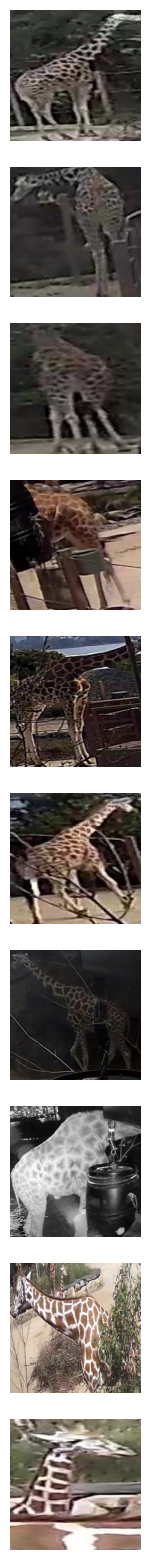

In [30]:
num_images = 10
fig, axs = plt.subplots(nrows=num_images, ncols=1, figsize=(6, 2*num_images))
for index, (item, ax) in enumerate(zip(itertools.islice(dataset, num_images),axs)):
    # print(f"Original image shape: {np.array(item[0]).shape}")
    # print(f"Pixel values range: min={np.min(np.array(item[0]))}, max={np.max(np.array(item[0]))}")
    ax.imshow(np.array(item[0]).transpose(1, 2, 0))
    ax.axis('off')
    

In [31]:

os.makedirs(outpath, exist_ok=True)

image_tensors = []
prediction_classes = []
known_classes = []
for item in itertools.islice(dataset, 10):
    image_tensors.append(item[0])
    known_classes.append(item[1])

print("set up baseline")

set up baseline


(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
(384, 384, 3)
Output type is <class 'detectron2.structures.instances.Instances'>
Available fields in the result: pred_boxes,scores,pred_classes,pred_masks
[]
<class 'detectron2.structures.boxes.Boxes'>
Output type is <class 'detectron2.structures.instances.Instances'>
Available fields in the result: pred_boxes,scores,pred_classes,pred_masks
[]
<class 'detectron2.structures.boxes.Boxes'>
Output type is <class 'detectron2.structures.instances.Instances'>
Available fields in the result: pred_boxes,scores,pred_classes,pred_masks
[]
<class 'detectron2.structures.boxes.Boxes'>
Output type is <class 'detectron2.structures.instances.Instances'>
Available fields in the result: pred_boxes,scores,pred_classes,pred_masks
[]
<class 'detectron2.structures.boxes.Boxes'>
Output type is <class 'detectron2.structures.instances.Instances'>
Available fields in the result: pred_boxe

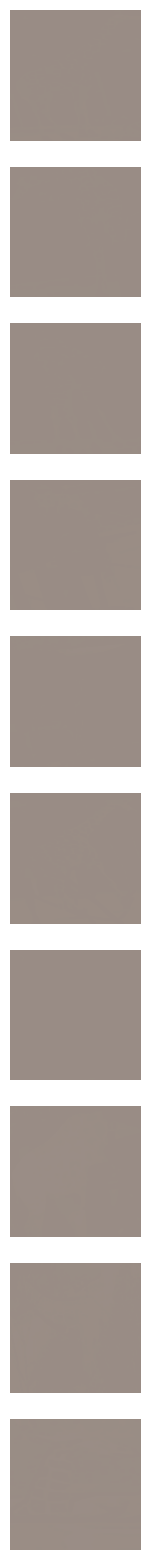

In [32]:
prediction = predict(image_tensors, model)


In [7]:



        # output: list[Individual] = []
        # prediction = predict(
        #     [image_tensor(
        #         self.__current_frame.image,
        #         self.__dimensions
        #     )],
        #     self.__model
        # )
        # # We assume we are only dealing with one prediction
        # # TODO: change the approach to merge the predictions (one detector for 3 images) here
        # prediction = prediction[0]["instances"]
        # _reids = list(prediction.get("reid_embeddings").cpu().numpy().flatten())
        # _classes = list(prediction.get("pred_classes").cpu().numpy())
        # _boxes = list(prediction.get("pred_boxes").cpu().numpy())
        # _masks = list(prediction.get("pred_masks").cpu().numpy())
        # _scores = list(prediction.get("scores").cpu().numpy())
        # for i in range(len(prediction)):
        #     if _classes[i] == 23:
        #         output.append(
        #             Individual(
        #                 # TODO: map reid and class values to a dict
        #                 #   This should be in the config
        #                 confidence=_scores[i],
        #                 identity=_reids[i],
        #                 species=_classes[i],
        #                 x_min=0.0, # TODO fix these
        #                 y_min=0.0,
        #                 x_max=0.0,
        #                 y_max=0.0,
        #                 mask=_masks[i],
        #                 timestamp=self.__current_frame.timestamp
        #             )
        #         )